STUDENT: JOAN ROSSELLO BOVER

Edited by Mohamed Sayed on 27/11/2019. All errors are now my own.
# Practical 7 - Part 1A

The aim of part 1A is to calculate the homography that best maps two sets of points to one another.  We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes.  You should use this
template for your code and fill in the missing sections marked "TO DO"


## Import libraries 

In [2]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.linalg import null_space # This is for the 2nd question of *** other things TO DO ***, for mapping 4 points

## Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [38]:
# Define a set of two-dimensional Cartesian points - row 0 is x coords, row 1 is y coords. Each column is a point --> world points (w) --> (u, v)
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])

# Convert points into homogeneous representation --> world points (w) --> (u, v, 1)
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Define a homography --> intrinsic param. * extrinsic param.
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points --> points in the image (x) in homogeneous representation --> lambda * (x, y, 1)
pts2Hom = np.matmul(H,pts1Hom)

# Convert back to Cartesian coordinates --> (x/lambda, y/lambda)
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1)) # we use np.tile to apply the lambda division of each column to both x and y
                                                          # and avoid having to do a for loop

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 4.0
# noiseLevel = 0.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

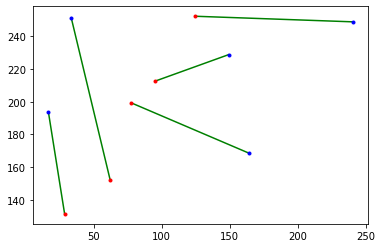

In [39]:
# Plot a green line between pairs of start points (blue) and transformed points (red).|
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

In the above figure we have plotted the two set of points - the blue points are the original points that would be observed in an original 2D plane, and the red points are the transformed blue points via a homographby that would be observed in a new 2D plane. The green line links the original red points with their respective red transformations.

## Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [4]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
    '''
    For the homogeneous equation Ah = 0, we can obtain h by:
    1) We decompose A into ULV' using SVD
    2) We take the last column of V as a starting estimation of h --> h0
    3) Use non-linear optimization starting with h0 to find final h that satisfies Ah = 0
    '''

    _, _, Vt = np.linalg.svd(A, full_matrices=True)
    V = np.transpose(Vt)
    h = V[:,-1].reshape((A.shape[-1],1)) # h0

    # *** THIS IS NOT REALLY NECESSARY - ignore when grading ***
    # # define loss function and its derivative
    # L = lambda h: np.sum((A @ h)**2) + (h.T @ h - 1)**2
    # dLdh = lambda h: 2 * (A @ (A @ h)) + 4 * (h.T @ h - 1) * h

    # # implement gradient descent
    # eps = np.inf
    # its = 0
    # lr = 0.01

    # while (eps > 0.001) and (its < 1000):
    #     step = - dLdh(h) * lr
    #     eps = np.max(np.abs(step))
    #     h += step
    #     its += 1
    
    return h

In [5]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    # H = np.identity(3) ??? - not necessary

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before  in the skeleton code we provide.
    pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1,pts2Cart.shape[1]))), axis=0)
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!
    A = np.zeros([n_points * 2, 9])

    x = pts2Hom[0,:]
    y = pts2Hom[1,:]
    u = pts1Hom[0,:]
    v = pts1Hom[1,:]

    for i in range(n_points):

        A[2*i,:] = np.array([[0, 0, 0, -u[i], -v[i], -1, y[i]*u[i], y[i]*v[i], y[i]]])
        A[2*i+1,:] = np.array([[u[i], v[i], 1, 0, 0, 0, -x[i]*u[i], -x[i]*v[i], -x[i]]])
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    if n_points == 4:
        h = null_space(A)
    else:
        h = solveAXEqualsZero(A)
    
    # Reshape h into the matrix H, values of h go first into rows of H
    H = np.reshape(h, (3,3))
    
    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. To do this we will apply our estimated mapping, `HEst`, to `pts1Cart` and obtain estimated points `pts2EstCart`. We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. The black lines represent the error between both points; if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Sqaured difference between pts2Cart and pts2EstCart is: 1.55


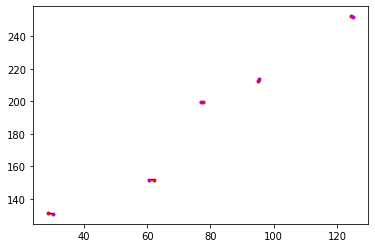

In [42]:
# Replace this with a call to the function calcBestHomography. You'll need to figure out which way around the 
# points go in the function, i.e. which direction this homography transforms points from and to. The ordering 
# is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.
HEst = calcBestHomography(pts1Cart, pts2Cart)

# HEst = 6 * HEst 

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Sqaured difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

We have extimated the 2nd set of points by:
1) calculating a homogrpahy that relates the 1st and 2nd set of points
2) re-calculate the 2nd set of points by applying the homography to the 1st set of points

We can observe that if we set the noiseLevel = 0, the points match perfectly because we can find the exact homography via SVD that solves the homogeneous problem Ah = 0. If we add noise, the SVD solution is just an approximation, there is not an exact homography that solves Ah = 0, but our result is a good estimate, and the estimated points should be close to their exact values (depending on the level of noise that has been applied - sampled from a normal distribution with std = 4 - when calculating the homography that relates the two sets of points).

## Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

2: Show empirically that your homography routine can EXACTLY map any four points to any
other four points.

1) Although there are 9 entries in the homography matrix, the homography only contains 8 degrees of freedom, so the entries are redundant up to scale. We obtain out homogeneous coordinates using the homography, and then when we divide the coordinates to transform to cartesian coordinates, we get rid of the sacling factor (lambda) and always obtain the same cartesian coordinates.

2) The minimum amount of points needed to find a homography is 4, since they form a problem Ah = 0, where A is an (8x9) matrix - 2 equations per point. The solution h is the null space of A. 
When using more points, we can use least squares to estimate the values of the homography matrix, but the solution is best found using single value decomposition (SVD) of A.
See code below for 4 points:

In [43]:
# create any 4 points in a coordinate grid from 0 to 100:
ptsW = np.random.rand(2,4) * 100
ptsX = np.random.rand(2,4) * 100

# if it was done with any 5 points, we would get a good first estimate with which we could start non-linear optimisation,
# but we wouldn't obtain an exact result straight away.

# estimate homography
H_est = calcBestHomography(ptsW, ptsX)

# calculate ptsX from ptsW using estimated homography
ptsWHom = np.concatenate((ptsW, np.ones((1,ptsW.shape[1]))), axis=0) # turn into homogeneous coords.
ptsXHom_est = np.matmul(H_est, ptsWHom) # ptsX estimate in homogeneous coords.

ptsX_est = ptsXHom_est[0:2,:] / np.tile([ptsXHom_est[2,:]],(2,1)) # convert back to cartesian coords.

# comparison check
np.set_printoptions(suppress=True)
print(f'four image points chosen at random = \n {ptsX} \n')
print(f'four image points calculated from four world points using estimated homography = \n {ptsX_est} \n')
print(f'absolute error = \n {np.abs(ptsX - ptsX_est)} \n')

four image points chosen at random = 
 [[71.10783108 85.99543032 12.02610707 67.85626001]
 [67.83698935 66.84304152 58.25571479 58.01322384]] 

four image points calculated from four world points using estimated homography = 
 [[71.10783108 85.99543032 12.02610707 67.85626001]
 [67.83698935 66.84304152 58.25571479 58.01322384]] 

absolute error = 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]] 



We can get any 2 sets of 4 random points and relate them exactly via a homography. The resulting absolute error is 0. This is not the case when we have more than 4 points. See the example below:

In [8]:
# create any 5 points in a coordinate grid from 0 to 100:
ptsW = np.random.rand(2,5) * 100
ptsX = np.random.rand(2,5) * 100

# estimate homography
H_est = calcBestHomography(ptsW, ptsX)

# calculate ptsX from ptsW using estimated homography
ptsWHom = np.concatenate((ptsW, np.ones((1,ptsW.shape[1]))), axis=0) # turn into homogeneous coords.
ptsXHom_est = np.matmul(H_est, ptsWHom) # ptsX estimate in homogeneous coords.

ptsX_est = ptsXHom_est[0:2,:] / np.tile([ptsXHom_est[2,:]],(2,1)) # convert back to cartesian coords.

# comparison check
np.set_printoptions(suppress=True)
print(f'four image points chosen at random = \n {ptsX} \n')
print(f'four image points calculated from four world points using estimated homography = \n {ptsX_est} \n')
print(f'absolute error = \n {np.abs(ptsX - ptsX_est)} \n')

four image points chosen at random = 
 [[40.36509561 86.55393923 18.76596407 14.59953383 14.31953489]
 [67.32665646 73.27023969 97.84607422 59.1809904  84.40766493]] 

four image points calculated from four world points using estimated homography = 
 [[ 34.53589617  80.44766513  17.45671807  22.17294759  24.1617925 ]
 [ -4.97673571  61.17290046  94.89582454  81.76340209 104.17019628]] 

absolute error = 
 [[ 5.82919944  6.1062741   1.309246    7.57341377  9.84225761]
 [72.30339218 12.09733923  2.95024968 22.58241168 19.76253135]] 

